# Google Trends insight in understanding what drives Norwegians into purchasing an electric vehicle
Authors: 
- 270226 - Max Chevron 
- 321733 - Shasha Jiang 
- 314205 - Jostein Leirgulen 

Date: 03.12.2020 

In [1]:
import pandas as pd 
from dateutil import relativedelta as rdelta
from datetime import datetime, date
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from pytrends.request import TrendReq
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.regression.linear_model as lm
from sklearn.metrics import mean_absolute_error

## Step 1 - Data wrangling

### Step 1.1 - EV sales and market share

In [2]:
sales = pd.read_csv('data/EV_sales_norway.csv',sep=';')

In [3]:
sales['weekday'] = ''
pd.to_datetime(sales['weekday'])
for index, row in sales.iterrows():
    # minus 1 because the dataset week system goes from 1 to 53 instead of 0 to 52, day start from sunday 0 to macth google trend
    sales.weekday[index] = datetime.strptime('{} {} 0'.format(row.year, row.week-1), '%Y %W %w').strftime("%Y-%m-%d") 
sales.weekday = pd.to_datetime(sales.weekday, format='%Y-%m-%d')
#compute market share for electric cars
sales['ev_share'] = sales['electric']/(sales['other'] + sales['electric'])
sales

C:\Users\Jostein\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,week,other,electric,weekday,ev_share
0,2010,1,17,0,2010-01-03,0.000000
1,2010,2,2776,0,2010-01-10,0.000000
2,2010,3,1953,0,2010-01-17,0.000000
3,2010,4,2078,0,2010-01-24,0.000000
4,2010,5,2873,0,2010-01-31,0.000000
...,...,...,...,...,...,...
572,2020,44,1749,1869,2020-11-01,0.516584
573,2020,45,961,1291,2020-11-08,0.573268
574,2020,46,1174,1435,2020-11-15,0.550019
575,2020,47,1259,1591,2020-11-22,0.558246


### Step 1.2 - Google trend data import and wrangling

In [4]:
# Function goal:      Convert start and end date to a string of dates with specific format
def convert_to_date(satrt,end):
      start = satrt.strftime("%Y-%m-%d")
      end = end.strftime("%Y-%m-%d")
      dates = start + ' ' + end
      return dates

In [5]:
'''
Function goal:      Split timespan in years
Function inputs:    date_start
                    date_end
Function outputs:   years_expand = Array years
'''

def split_data_into_year(date_start, date_end):
    years_expand = []
    start_year = date_start
    while abs(rdelta.relativedelta(start_year,date_end).years) >0 :
      one_year = rdelta.relativedelta(weeks=+50)
      end_year = start_year + one_year
    
      years_expand += [convert_to_date(start_year,end_year)]

      #update start_year
      one_week = rdelta.relativedelta(weeks=+1)
      start_year = end_year + one_week

    years_expand += [convert_to_date(start_year,date_end)]
    return years_expand

In [6]:
'''
Function goal:      Import Google Trends data
Function inputs:    kw = Keyword list 
                    geo = Country abreviation to search
                    dates = Timespan to search
                    eps = maximum propensity difference in matching
Function outputs:   pytrends = full pytrends format dataset
                    interest_over_time_df = Dataframe containing the interest evolution for each keyword
'''

def build_GT_data(kw, geo, dates):

    while True:
        try:
            pytrends.build_payload(kw_list=kw, cat=0, timeframe=dates, geo=geo, gprop='')
            break
        except:    
            pass # Sometimes Google Trends rejects the request. Try again until it works ! 

    interest_over_time_df = pytrends.interest_over_time()

    return interest_over_time_df[kw]

In [7]:
'''
Function goal:      Normalise the weekly values. It finds the date and keyword with the max value in weekly. 
                    Looks for the value in the monthly dataset which is smaller and normalises all the weekly value to this one.
Function inputs:    data_weekly = 1 year of Google Trends data with weekly granularity
                    data_monthly = Whole deseired timespan of Google Trends data with monthly granularity
                    kw = keywords
Function outputs:   data_weekly = same as input but normalised 
'''
def normalise(data_weekly, data_monthly, kw):
    # 1) Convert weekly into monthly with mean()
    data = data_weekly.groupby(data_weekly.index.strftime("%Y-%m")).mean()

    # 2) Find row index and column name of max value (which is not 100 as we have done the mean over 4 weeks)
    yearly_max = data.max().max()
    max_column = data.max().idxmax()
    max_row = data[max_column].idxmax()

    # 3) For the whole timespan (with monhtly datapoints), the value at the weekly max is 'true_max' 
    true_max = data_monthly[max_column].loc[data_monthly.index > max_row].iloc[0]

    # 4) Normalise each weekly datapoints by this true_max/yearly_max in %
    data_weekly = data_weekly*(true_max/yearly_max)/100

    return data_weekly

In [8]:
'''
Function goal:      Split the timespan in years so that we can extract weekly datapoints. 
Function inputs:    data_weekly = 1 year of Google Trends data with weekly granularity
                    interest_monthly = Whole deseired timespan of Google Trends data with monthly granularity
                    kw = keywords
                    yrs = full timespan split into years 'start_date end_date' for each year as a list
                    geo = Country abreviation to search
Function outputs:   interest = full timespan interest with weekly datapoints
'''
def get_weekly_interest(interest_monthly, kw, yrs, geo):
    interest = pd.DataFrame()
    for yearly_dates in yrs:
        interest_weekly = build_GT_data(kw, geo, yearly_dates)
        
        #if the search is for very short timespan it will result in daily instead of weekly values. So we take the weekly mean in case this happens
        interest_weekly['date'] = pd.to_datetime(interest_weekly.index) - pd.to_timedelta(7, unit='d')
        interest_weekly = interest_weekly.groupby(pd.Grouper(key='date', freq='W-SUN')).mean()
        
        interest_weekly = normalise(interest_weekly, interest_monthly, kw)
        interest = pd.concat([interest, interest_weekly])
    #The max week might actually not be around the same date as the max month. Hence we need to normalise again here so that max value is 100
    interest = interest/interest.max().max()*100
    return interest

In [9]:
UTC_offset = 60 # Minutes for Norway (UTC+1)
host_language = 'en_US'
# keywords related to category: economical 
kw_eco = ["Elbil bompenger", "Elbil avgift", "Elbil pris", "Elbil fordeler", "Bompenger"] # REMOVED:, "Bompenger pris", "Parkering pris", "Elbil parkering"] 
# keywords related to category: EV models (top 10 EV models sold in Norway with Tesla models grouped together as 'Tesla')
kw_evm = ["Tesla", "Nissan Leaf","Volkswagen e-Golf", "Bmw I3", "Kia Soul"] # REMOVED:, "Renault Zoe", "Audi E-tron", "Hyundai Ioniq"] 
# keywords related to category: range anxiety 
kw_ran = ["Elbil lading", "Elbil ladestasjoner", "Ladestasjoner", "Hurtiglading", "Elbil rekkevidde"] # REMOVED:, "Tesla supercharger"] 
# keywords related to category: environement 
kw_env = ["Karbonavtrykk", "Luftkvalitet", "CO2", "CO2 bil", "CO2 utslipp"] 
# all keywords grouped
kw_all = kw_eco + kw_evm + kw_ran + kw_env
#date_start = date(2009,12,28) # Sales dataset Timespan
#date_end = date(2020,11,29)
date_start = date(2010,1,3)
date_end = date(2020,1,5)
dates = convert_to_date(date_start,date_end)
yrs = split_data_into_year(date_start, date_end) # Will be usefull to extract yearly datasets to have weekly instead of monthly datapoints
country_abbreviation = 'NO' #Norway abreviation
pytrends = TrendReq(hl=host_language, tz=UTC_offset)

In [10]:
# Step 1: get non granular over results for reference:
# Giving a too large timespan yields unfortunately only monthy results. This will however serve as our reference frame for normalisation
interest_monthly_kw_eco = build_GT_data(kw_eco, country_abbreviation, dates)
interest_monthly_kw_evm = build_GT_data(kw_evm, country_abbreviation, dates)
interest_monthly_kw_ran = build_GT_data(kw_ran, country_abbreviation, dates)
interest_monthly_kw_env = build_GT_data(kw_env, country_abbreviation, dates)

In [11]:
#Step 2: get weekly 
interest_kw_eco = get_weekly_interest(interest_monthly_kw_eco, kw_eco, yrs, country_abbreviation)
interest_kw_evm = get_weekly_interest(interest_monthly_kw_evm, kw_evm, yrs, country_abbreviation)

#NOTE: GOOGLE DOES WEIRD THINGS SOMETIMES. SO YOU MIGHT NEED TO RUN A LINE AGAIN INDIVIDUALLY IF YOU HAVE AN ERROR
#For me it seems like its mainly for 'ran' that it fails but after a while if you run this line individually it works
# When you do too many queries you get rejected by Google Trends. You need to pause before starting again to avoid errors. 60 sec is recommended by pytrends
# Doesn't seem to work though ...
#time.sleep(60) 

interest_kw_ran = get_weekly_interest(interest_monthly_kw_ran, kw_ran, yrs, country_abbreviation)
interest_kw_env = get_weekly_interest(interest_monthly_kw_env, kw_env, yrs, country_abbreviation)

### Step 1.3 - Key events definition

In [12]:
# Economical related dates which penalises combustion vehicles (in favor of EV)
dates_eco = {"Climate settlement announcement":"2012-04-24",
             "Kyoto agreement second term":"2013-05-31"}

# EV model key releas dates
# Unknown date of the month for dates_evm so set to 15
dates_evm = {"Tesla model 3 first release":"2019-07-15",
             "Nissan Leaf first release":"2010-12-15"}

# Range anxiety mitigation key dates
dates_ran = {"Tesla supercharging system start":"2013-07-01"}

# Rising environmental awarness key dates
dates_env = {"Paris agreement anouncement":"2015-01-04",
             "Paris agreement updated emission cuts":"2020-02-27"}

# All dates together
dates_all = dict(dates_eco)
dates_all.update(dates_evm)
dates_all.update(dates_ran)
dates_all.update(dates_env)

In [13]:
sales_base = sales.copy()

# convert rows to month or year where each row is 1 week
#month_delay = 4
year_delay = 52

#a fix - t-1 should not be 4, which would imply we are trying to use last years week, and four weeks past in order 
# to predict NOW
week_delay = 1

# BOTH LOG AND LINEAR COLUMNS HERE. REMOVE ONE OR THE OTHER WHEN DECIDED: 
sales_base['ev_share_tm1']=sales_base.ev_share.shift(week_delay)
sales_base['ev_share_tm12']=sales_base.ev_share.shift(year_delay)
#replace 0 to a samll number bigger than 1 so that log can be defined
#sales_base['log_ev_share'] = np.log(sales_base.ev_share.replace(0, 0.5))
#sales_base['log_ev_share_tm1']=sales_base.log_ev_share.shift(month_delay)
#sales_base['log_ev_share_tm12']=sales_base.log_ev_share.shift(year_delay)

### Modifications by JOSTEIN
sales_base['log_ev_share'] = np.log(sales_base.ev_share + 0.1)
sales_base['log_ev_share_tm1']=sales_base.log_ev_share.shift(week_delay)
sales_base['log_ev_share_tm12']=sales_base.log_ev_share.shift(year_delay)

### Dataframes for statsmodels

In [14]:
df_sales = sales_base.iloc[:528,:].drop_duplicates(subset='weekday').set_index('weekday')
df_inter_eco = interest_kw_eco.iloc[1:,:]
df_inter_evm = interest_kw_evm.iloc[1:,:]
df_inter_ran = interest_kw_ran.iloc[1:,:]
df_inter_env = interest_kw_env.iloc[1:,:]

In [15]:
df_inter = df_inter_eco.merge(df_inter_evm, left_index=True, right_index=True)
df_inter = df_inter.merge(df_inter_ran, left_index=True, right_index=True)
df_inter = df_inter.merge(df_inter_env, left_index=True, right_index=True)
df_inter

,Elbil bompenger,Elbil avgift,Elbil pris,Elbil fordeler,Bompenger,Tesla,Nissan Leaf,Volkswagen e-Golf,Bmw I3,Kia Soul,Elbil lading,Elbil ladestasjoner,Ladestasjoner,Hurtiglading,Elbil rekkevidde,Karbonavtrykk,Luftkvalitet,CO2,CO2 bil,CO2 utslipp
date,,,,,,,,,,,,,,,,,,,,
2010-01-03,0.000000,0.0,0.000000,0.000000,9.943891,0.514042,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,31.619132,0.0,6.587319
2010-01-10,0.000000,0.0,0.000000,4.850679,0.000000,0.995956,0.514042,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.928587,30.960400,0.0,0.000000
2010-01-17,0.000000,0.0,0.000000,0.000000,14.309502,0.995956,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,18.444494,0.0,0.000000
2010-01-24,0.000000,0.0,0.000000,0.000000,0.000000,0.481914,0.000000,0.0,0.000000,0.481914,0.000000,0.000000,13.319728,0.000000,0.000000,0.0,5.928587,65.873192,0.0,5.928587
2010-01-31,0.000000,0.0,0.000000,0.000000,9.458824,0.481914,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,24.373081,0.0,5.928587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,2.647904,0.0,2.647904,0.000000,28.645509,34.661355,2.788845,0.0,1.992032,0.000000,25.062114,0.000000,35.042602,5.766504,16.855935,0.0,2.447871,61.419307,0.0,5.563343
2019-12-08,0.000000,0.0,8.545509,0.000000,35.144910,31.872510,2.788845,0.0,1.593625,0.398406,23.287805,0.000000,29.276098,5.544715,19.295610,0.0,4.895742,83.227611,0.0,7.788680
2019-12-15,0.000000,0.0,4.573653,2.768263,31.654491,32.669323,1.593625,0.0,0.796813,1.195219,6.875447,13.750894,50.124228,6.875447,26.392846,0.0,2.892938,32.712457,0.0,10.236551


## AR using Statsmodels

In [17]:
'''
Function Goal: Plot either baseline or model with keywords
Function input: sales - df with "ev_sales" as a column
                trends - df containing all google trends data
                keywords - list specifying which trends to use
                n_test - number of weeks that will be used for training
Function output: List of predicted sales using the fitted model

HOW TO PLOT BASELINE: Just pass sales (or market share), nothing else
HOW TO PLOT IMPROVED: Pass sales, trends and keywords
'''

def pred_sales_AR(sales_df, trends=None, keywords=[], n_test=17*4):
    
    ## Instantiate models - create baseline if no trends dataframe is passed
    if trends is None:
        AR_model = AutoReg(sales_df["ev_share"],
                           lags=[1, 52],
                           hold_back = n_test,
                           old_names=False)
    else:
        AR_model = AutoReg(sales_df["ev_share"],
                           lags=[1, 52],
                           hold_back = n_test,
                           exog=trends[keywords],
                           old_names=False)
    
    ## Fit model
    AR_fit = AR_model.fit()
    
    ## Predict values using model
    pred_sales = AR_fit.predict(start=n_test) 

    ## Print summary
    display(AR_fit.summary())
    
    return pred_sales

In [18]:
def calc_MAE(sales_df, baseline, improved, n_test=17*4):
    
    ## Slice out test set
    df_sales_test = sales_df.iloc[n_test:,:]
    
    ## Calculate totall MAE
    baseline_MAE = mean_absolute_error(df_sales_test["ev_share"], baseline)
    improved_MAE = mean_absolute_error(df_sales_test["ev_share"], improved)
    
    ## Calculate overall improvement and return it
    return ((baseline_MAE-improved_MAE)/baseline_MAE)*100

In [38]:
df_inter

,Elbil bompenger,Elbil avgift,Elbil pris,Elbil fordeler,Bompenger,Tesla,Nissan Leaf,Volkswagen e-Golf,Bmw I3,Kia Soul,Elbil lading,Elbil ladestasjoner,Ladestasjoner,Hurtiglading,Elbil rekkevidde,Karbonavtrykk,Luftkvalitet,CO2,CO2 bil,CO2 utslipp
date,,,,,,,,,,,,,,,,,,,,
2010-01-03,0.000000,0.0,0.000000,0.000000,9.943891,0.514042,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,31.619132,0.0,6.587319
2010-01-10,0.000000,0.0,0.000000,4.850679,0.000000,0.995956,0.514042,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.928587,30.960400,0.0,0.000000
2010-01-17,0.000000,0.0,0.000000,0.000000,14.309502,0.995956,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,18.444494,0.0,0.000000
2010-01-24,0.000000,0.0,0.000000,0.000000,0.000000,0.481914,0.000000,0.0,0.000000,0.481914,0.000000,0.000000,13.319728,0.000000,0.000000,0.0,5.928587,65.873192,0.0,5.928587
2010-01-31,0.000000,0.0,0.000000,0.000000,9.458824,0.481914,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,24.373081,0.0,5.928587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,2.647904,0.0,2.647904,0.000000,28.645509,34.661355,2.788845,0.0,1.992032,0.000000,25.062114,0.000000,35.042602,5.766504,16.855935,0.0,2.447871,61.419307,0.0,5.563343
2019-12-08,0.000000,0.0,8.545509,0.000000,35.144910,31.872510,2.788845,0.0,1.593625,0.398406,23.287805,0.000000,29.276098,5.544715,19.295610,0.0,4.895742,83.227611,0.0,7.788680
2019-12-15,0.000000,0.0,4.573653,2.768263,31.654491,32.669323,1.593625,0.0,0.796813,1.195219,6.875447,13.750894,50.124228,6.875447,26.392846,0.0,2.892938,32.712457,0.0,10.236551


In [57]:
'''
Function goal: Plot models over empirical data
'''

def plot_AR(sales, baseline, improved, zoom_year=False):
    
    ## Create figure
    fig, ax = plt.subplots()
    
    ## Plot empirical
    sales["ev_share"].plot(figsize=(15,5))
    
    ## Iteratively plot predicted
    baseline.plot(figsize=(15,5))
    improved.plot(figsize=(15,5))

    ### Add legend
    plt.legend((['Actual', 'Base', 'Improved']))

    ### Add axis label and header
    ax.set_ylabel('Market Share')
    ax.set_xlabel('Date')
    ax.set_title('Market share of EV-vehicles in Norway')
    
    if(zoom_year):
        ax.set_xlim([date(2018, 1, 1), date(2019,1,1)])

In [58]:
all_keywords = df_inter.columns.to_list()
all_keywords

['Elbil bompenger',
 'Elbil avgift',
 'Elbil pris',
 'Elbil fordeler',
 'Bompenger',
 'Tesla',
 'Nissan Leaf',
 'Volkswagen e-Golf',
 'Bmw I3',
 'Kia Soul',
 'Elbil lading',
 'Elbil ladestasjoner',
 'Ladestasjoner',
 'Hurtiglading',
 'Elbil rekkevidde',
 'Karbonavtrykk',
 'Luftkvalitet',
 'CO2',
 'CO2 bil',
 'CO2 utslipp']

In [59]:
pred_sales_baseline = pred_sales_AR(df_sales)
pred_sales_improved = pred_sales_AR(df_sales, df_inter, keywords=["Tesla", "Elbil lading"])

C:\Users\Jostein\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               ev_share   No. Observations:                  522
Model:             Restr. AutoReg(52)   Log Likelihood                 808.944
Method:               Conditional MLE   S.D. of innovations              0.041
Date:                Wed, 16 Dec 2020   AIC                             -6.384
Time:                        20:39:54   BIC                             -6.348
Sample:                    04-24-2011   HQIC                            -6.370
                         - 12-29-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0070      0.003      2.293      0.022       0.001       0.013
ev_share.L1      0.7965      0.027     29.906      0.000       0.744       0.849
ev_share.L52     0.2265      0.034      6.688      0.000       0.160       0.293
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9981           -0.0000j            0.9981           -0.0000
AR.2             0.9937           -0.1128j            1.0001           -0.0180
AR.3             0.9937           +0.1128j            1.0001            0.0180
AR.4             0.9784           -0.2275j            1.0045           -0.0364
AR.5             0.9784           +0.2275j            1.0045            0.0364
AR.6             0.9494           -0.3426j            1.0093           -0.0551
AR.7             0.9494           +0.3426j            1.0093            0.0551
AR.8             0.9057           -0.4552j            1.0136           -0.0741
AR.9             0.9057           +0.4552j            1.0136            0.0741
AR.10            0.8476           -0.5626j            1.0173           -0.0933
AR.11            0.8476           +0.5626j            1.0173            0.0933
AR.12            0.7760           -0.6627j            1.0205           -0.1125
AR.13            0.7760           +0.6627j            1.0205            0.1125
AR.14            0.6921           -0.7537j            1.0233           -0.1318
AR.15            0.6921           +0.7537j            1.0233            0.1318
AR.16            0.5972           -0.8339j            1.0257           -0.1511
AR.17            0.5972           +0.8339j            1.0257            0.1511
AR.18            0.4928           -0.9019j            1.0278           -0.1704
AR.19            0.4928           +0.9019j            1.0278            0.1704
AR.20            0.3804           -0.9568j            1.0296           -0.1898
AR.21            0.3804           +0.9568j            1.0296            0.1898
AR.22            0.2619           -0.9974j            1.0312           -0.2091
AR.23            0.2619           +0.9974j            1.0312            0.2091
AR.24            0.1391           -1.0233j            1.0327           -0.2285
AR.25            0.1391           +1.0233j            1.0327            0.2285
AR.26            0.0138           -1.0339j            1.0340           -0.2479
AR.27            0.0138           +1.0339j            1.0340            0.2479
AR.28           -0.1120           -1.0290j            1.0351           -0.2673
AR.29           -0.1120           +1.0290j            1.0351            0.2673
AR.30           -0.2364           -1.0088j            1.0361           -0.2866
AR.31           -0.2364           +1.0088j            1.0361         

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:                 ev_share   No. Observations:                  522
Model:             Restr. AutoReg-X(52)   Log Likelihood                 814.159
Method:                 Conditional MLE   S.D. of innovations              0.040
Date:                  Wed, 16 Dec 2020   AIC                             -6.398
Time:                          20:39:54   BIC                             -6.344
Sample:                      04-24-2011   HQIC                            -6.377
                           - 12-29-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0014      0.004      0.411      0.681      -0.005       0.008
ev_share.L1      0.7451      0.031     23.874      0.000       0.684       0.806
ev_share.L52     0.2224      0.034      6.562      0.000       0.156       0.289
Tesla            0.0007      0.000      3.223      0.001       0.000       0.001
Elbil lading -1.096e-05      0.000     -0.057      0.955      -0.000       0.000
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0025           -0.0000j            1.0025           -0.0000
AR.2             0.9972           -0.1148j            1.0038           -0.0182
AR.3             0.9972           +0.1148j            1.0038            0.0182
AR.4             0.9803           -0.2303j            1.0070           -0.0367
AR.5             0.9803           +0.2303j            1.0070            0.0367
AR.6             0.9500           -0.3453j            1.0108           -0.0555
AR.7             0.9500           +0.3453j            1.0108            0.0555
AR.8             0.9056           -0.4575j            1.0145           -0.0744
AR.9             0.9056           +0.4575j            1.0145            0.0744
AR.10            0.8471           -0.5644j            1.0179           -0.0935
AR.11            0.8471           +0.5644j            1.0179            0.0935
AR.12            0.7753           -0.6642j            1.0209           -0.1127
AR.13            0.7753           +0.6642j            1.0209            0.1127
AR.14            0.6912           -0.7548j            1.0235           -0.1320
AR.15            0.6912           +0.7548j            1.0235            0.1320
AR.16            0.5963           -0.8346j            1.0257           -0.1513
AR.17            0.5963           +0.8346j            1.0257            0.1513
AR.18            0.4918           -0.9024j            1.0278           -0.1706
AR.19            0.4918           +0.9024j            1.0278            0.1706
AR.20            0.3795           -0.9570j            1.0296           -0.1899
AR.21            0.3795           +0.9570j            1.0296            0.1899
AR.22            0.2611           -0.9975j            1.0311           -0.2093
AR.23            0.2611           +0.9975j            1.0311            0.2093
AR.24            0.1383           -1.0233j            1.0326           -0.2286
AR.25            0.1383           +1.0233j            1.0326            0.2286
AR.26            0.0131           -1.0337j            1.0338           -0.2480
AR.27            0.0131           +1.0337j            1.0338            0.2480
AR.28           -0.1126           -1.0288j            1.0350           -0.2673
AR.29           -0.1126           +1.0288j     

In [60]:
MAE_improvement = calc_MAE(df_sales, pred_sales_baseline, pred_sales_improved)
MAE_improvement

1.8230763950788167

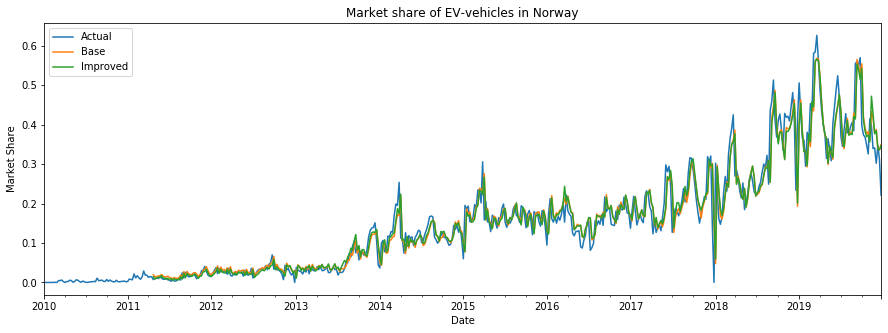

In [61]:
plot_AR(df_sales, pred_sales_baseline, pred_sales_improved)

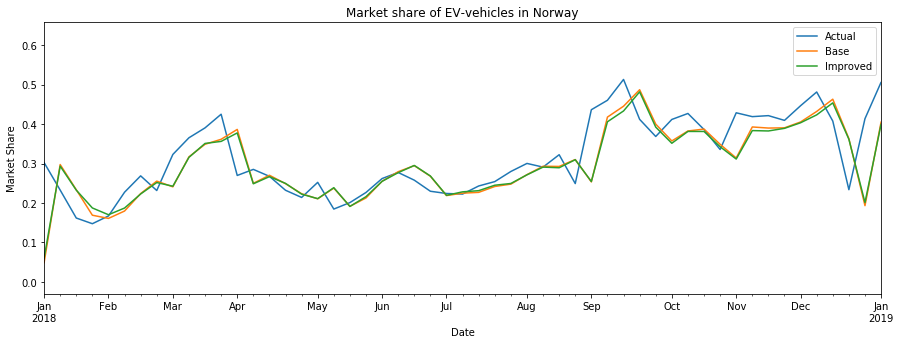

In [62]:
plot_AR(df_sales, pred_sales_baseline, pred_sales_improved, zoom_year=True)